# EcoFOCIpy SBE39 2341 QC

see [EcoFOCIpy_21ckp9a_s37_2341.ipynb](EcoFOCIpy_21ckp9a_s37_2341.ipynb) for initial processing and formatting.  Data would have been convertted from raw instrument format to csv files, initial dirty plots created and a meta-data rich and meta-data poor dataset would have been created.  The metadata poor csv file is used for the initial preliminary data archive, the metadata rich netcdf file is used for QC procedures and eventual final data archive.

## Next Steps

QC of data (plot parameters with other instruments)
- be sure to updated the qc_status and the history

- **TODO** Programmatically simplify following tools

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
import yaml

import pandas as pd
import xarray as xr
import datetime
import ecofocipy.io.erddap as erddap

import ecofocipy.metaconfig.load_config as load_config

In [26]:
sample_data_dir = '/Users/bell/Programs/EcoFOCIpy/'
user_data_dir = '/Users/bell/ecoraid/2020/Moorings/20ckp9a/'

In [27]:
###############################################################
# edit to point to {instrument sepcific} raw datafile 
datafile = user_data_dir+'raw/sbe37/20ckp9a_sbe37_2341_949m.asc'
instrument = 'SBE-37 2341'
mooring_meta_file = user_data_dir+'logs/20CKP-9A.yaml'
inst_meta_file = sample_data_dir+'staticdata/instr_metaconfig/sbe37_cf.yaml'
institution_meta_file = sample_data_dir+'staticdata/institutional_meta_example.yaml' #include uaf?
inst_shortname = 's37'
###############################################################

In [28]:
#just a dictionary of dictionaries - simple
with open(mooring_meta_file) as file:
    mooring_config = yaml.full_load(file)

In [29]:
# this task only needed to be run once in the initial processing routine
# (sbe37_wop_nc.autotrim_time().to_dataframe()).to_csv(filename.replace('nc','csv')) #because the raw archived csv file doesn't trim out deck data, start with this file to edit 

#if it wasn't run, you can ingest the working netcdf file -> export it to csv as it should have been saved as a trimmed file, and work on that csv for manual edits
depth = str(int(mooring_config['Instrumentation'][instrument]['ActualDepth'])).zfill(4)
filename = "".join(mooring_config['MooringID'].split('-')).lower()+'_'+inst_shortname+'_'+str(depth).zfill(4)+'m.nc'
sbe37_wop_nc = xr.load_dataset(user_data_dir+'working/'+filename)


In [30]:
# this reads the previous csv and assumes you've made modifications to the content but not the structure (record length or variable names)
try:
    sbe37_df_qc = pd.read_csv(user_data_dir+'working/'+filename.replace('nc','csv'), index_col=['time','depth','latitude','longitude']) #order is important
except:
    sbe37_df_qc = pd.read_csv(user_data_dir+'working/'+filename.replace('nc','csv'), index_col=['time (UTC)','depth (m)','latitude (degrees_north)','longitude (degrees_east)']) #order is important


In [31]:
sbe37_wop_nc

<xarray.Dataset>
Dimensions:       (time: 18224, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time          (time) datetime64[ns] 2020-09-15T11:00:00 ... 2022-10-14T18...
  * latitude      (latitude) float64 72.47
  * longitude     (longitude) float64 -156.6
  * depth         (depth) float64 270.0
Data variables:
    temperature   (time, depth, latitude, longitude) float64 0.1811 ... 0.1774
    conductivity  (time, depth, latitude, longitude) float64 2.901 2.9 ... 2.901
    pressure      (time, depth, latitude, longitude) float64 268.3 ... 266.3
    salinity      (time, depth, latitude, longitude) float64 34.59 34.6 ... 34.6
Attributes: (12/33)
    Latitude_DegMMddW:                      72 28.21 N
    Longitude_DegMMddN:                     156 33.51 W
    MooringID:                              20CKP-9A
    platform_deployment_date:               2020-09-15T10:19:00Z
    platform_deployment_cruise_name:        DY2012
    platform_recovery_date:                 2022-10-14T18:07:00Z
    ...                                     ...
    InstrumentSerialNumber:                 2341
    InstrumentType:                         SBE-37
    date_created:                           2022-11-02T11:43:07Z
    date_modified:                          
    QC_indicator:                           unknown
    history:                                Trimmed to deployment.

In [32]:
#replace original data with editied data
sbe37_wop_nc['temperature'].values=xr.Dataset.from_dataframe(sbe37_df_qc)['temperature']
sbe37_wop_nc['salinity'].values=xr.Dataset.from_dataframe(sbe37_df_qc)['salinity']
sbe37_wop_nc['conductivity'].values=xr.Dataset.from_dataframe(sbe37_df_qc)['conductivity']

<div class="alert alert-warning">
    <p>
        Ingest edited version of csv file
    </p>
</div>


In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import ecofocipy.io.erddap as erddap
import xarray as xr
import datetime

url = "http://akutan.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [34]:
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2012',qclevel='preliminary',concastno='064')
# reccast = erddap.erddapCTDretrieve(url=url,cruiseid='SKQ202115S',qclevel='preliminary',concastno='009')


some variable names switch between preliminary and final... this will eventually be resolved

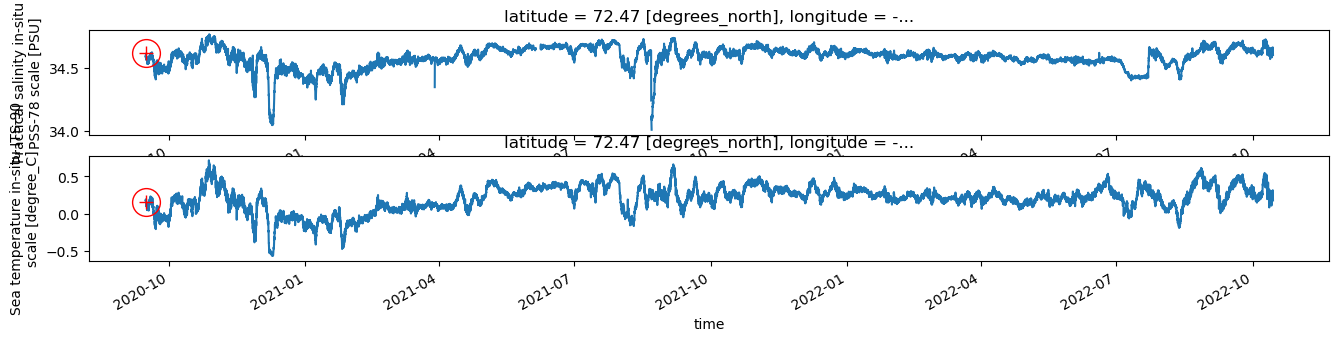

In [35]:
#plot ctd values with a small circular radius and zoom in on near their equivalent mooring time span, we are looking for visual discrepencies
#cycle through each depth and plot respective plot
depth = int(mooring_config['Instrumentation'][instrument]['ActualDepth'])
# depth= 40 #instrument deeper than ctd cal, use deepest point

fig, ax = plt.subplots(2,figsize=(16, 3))
sbe37_wop_nc.salinity.plot(x="time",hue="depth",ax=ax[0], add_legend=False);
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['S_41 (PSU)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[0].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['S_41 (PSU)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

sbe37_wop_nc.temperature.plot(x="time",hue="depth",ax=ax[1], add_legend=False);
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['T_28 (degree_C)'],
        'o',markersize=20,markerfacecolor='none',markeredgecolor='red')
ax[1].plot(pd.to_datetime(depcast[depcast['pressure'] == depth]['time (UTC)']),
        depcast[depcast['pressure'] == depth]['T_28 (degree_C)'],
        '+',markersize=10,markerfacecolor='none',markeredgecolor='red')

### Update global attributes

In [36]:
sbe37_wop_nc.attrs.update({'QC_indicator': 'ProbablyGood'})
sbe37_wop_nc.attrs.update({'history':(sbe37_wop_nc.history + "\nQCd: "+ str(datetime.datetime.today()))})

In [37]:
sbe37_wop_nc.attrs.update({'date_modified':str(datetime.datetime.today())})

In [38]:
sbe37_wop_nc.to_netcdf(user_data_dir+'working/'+filename,format="NETCDF3_CLASSIC",encoding={'time':{'units':'days since 1900-01-01'}})